# Importance sampling

Illustrated with a specific example of importance-sampling an existing MCM chain.

## Monte-Carlo integration

An integral

$$F = \int_a^b {\rm d} x \, f(x) $$

can be approximated by evaluating $f$ at random points, drawn from a uniform distribution
between $a$ and $b$:

$$\int_a^b {\rm d} x \, f(x) \approx \frac{b-a} N \sum_{i=1}^N f(x_i),$$

with sample points written as

$$x_i ~ \sim U_{[a; b]}.$$

This is illustrated in the following example. We pick uniformly drawn random points $x_i$
and compute the area of the rectangle between $a = -2$ and $b = 5$, which is $(b - a) f(x_i)$.

An (unbiased) estimate of the grey area is the average of all rectangles, which is the above equation.

<img src="example_MC.jpeg" />
(From https://towardsdatascience.com/the-basics-of-monte-carlo-integration-5fe16b40482d)

## Drawing from arbitrary distributions

$$F = \int_a^b {\rm d} x f(x) = \int {\rm d} y \, p(y) f(y)$$

with variable change

$${\rm d} y \, p(y) = \frac{{\rm d} x}{b-a}$$,

where $p$ is a normalised probability distribution $\int {\rm d} y \, p(y) = 1$.

This is approximated by

$$F \approx \frac 1 N \sum_{i=1}^N f(y_i)$$

with random points $y_i$ drawn from the distribution $p$, $y \sim p$.

Proof:

$$E \left[ \frac 1 N \sum_{i=1}^N f(y_i) \right] = \frac 1 N \sum_{i=1}^N E \left[ f(y_i) \right]
= \frac 1 N \sum_{i=1}^N \int {\rm d} y \, p(y) f(y)
= \frac 1 N N F = F
$$

## Monte-Carlo Markov chain

A Monte-Carlo Markov chain of points $\{x_i \}_{i=1}^N$ represents, when converged, a sample under a posterior distribution $p(x) \propto \pi(x) L(x)$, with $\pi$ being the prior and $L$ the likelihood function. We write as above

$$x \sim p.$$

This allows us to estimate (high-dimensional) integrals of the form

$$\int {\rm d} x \, p(x) f(x) = \int {\rm d} x \, \pi(x) L(x) f(x).$$

The (unbiased) estimator is

$$ \int {\rm d} x \, p(x) f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i),$$

which is just the normalised sum over the function $f$ evaluated at all chain points.

For example, for the mean of a parameter we set $f(x) = x$. The mean estimated by MCMC is simply

$$\bar x \approx \frac 1 N \sum_{i=1}^N x_i.$$

Another example: To plot the 2D $68\%$ credible region (contour), pixelise $p$ in 2D, sort the pixels by density (= number of sample points in each pixel), and set $f = 1$ in the first $68\%$ of pixels, and $0$ for the remaining pixels.

## Importance sampling

Importance sampling is based on the following identity

$$\int {\rm d} x \, p(x) f(x) = \int {\rm d} x \, q(x)\frac{p(x)}{q( x)} f(x),$$

which holds if the support of the proposal distribution $q$ is not smaller than the support of $p$.

This integral can be estimated with samples under $q$ instead of $p$,

$$y \sim q,$$

if the samples are multiplied by the importance weights

$$w_i = \frac{p(x_i)}{q(x_i)},$$

since

$$ \int {\rm d} x \, p(x) f(x) = \int {\rm d} x \, q(x)\frac{p(x)}{q( x)} f(x) \approx \frac 1 N \sum_{i=1}^N w_i f(y_i).$$

Importance sampling can be useful if sampling under $p$ is very time-consuming of difficult, but evaluating $p$ at points $x_i$ is not. One then choses a simple proposal function $q$, e.g. a (multi-variate) normal.

Importance sampling permits to separate sampling (fast; under $q$) and evaluating the original posterior (potentiall slow, but can now be done in parallel using the already sampled points $x_i$).

### Importance-sampling an existing MCM chain

A recurring case is the following. We have already run an MCMC and obtained samples $x \sim p$ under the posterior $p(x) = \pi(x) L(x)$.

Next, we would like to get samples under a new, combined, posterior $p_{\rm comb}(x) = \pi(x) L(x) L_2(x)$. For example, $L$ is the CMB likelihood, $L_2$ is the one for weak lensing. We want to get the combined weak-lensing + CMB constraints.

Now, instead of re-running a new chain sampling from $p_{\rm comb}$, we can see that the integral

$$\int {\rm d} x p_{\rm comb} f(x) = \int {\rm d} x \pi(x) L(x) L_2(x) f(x)$$

has a form similar to the modified one above, if we identify

$$q(x) = \pi(x) L(x) \quad \mbox{and} \quad L_2(x) = \frac{p(x)}{q(x)}.$$

So we can use the existing chain points $x_i$ sampled under $p=q$ and  multiply each data point $x_i$ with the "importance weight" $L_2(x_i)$, and can thus obtain estimators of integrals with the combined posterior $p_{\rm comb}$!

Let's test this.

In [34]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import emcee

First, we sample a 1-D distribution with emcee to see whether this simple case works.

In [35]:
# Define simple log of a 1D normal distribution with mean μ and width σ
def log_prob(x, μ, σ):
    diff = x - μ
    return -0.5 * (diff / σ)**2

In [36]:
# Input values
μ = 0
σ = 3

In [37]:
# Set x array for plotting
n = 5
x = np.linspace(-σ*n, σ*n, 1000)

In [38]:
# Set up MCMC
ndim = 1
nwalkers = 5

# Random starting points
p0 = np.random.rand(nwalkers, ndim)

In [39]:
# Initialise emcee samples
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[μ, σ])
n_burn = 100
n_chain = 5000

In [40]:
# Run burn-in phase and remove points from chain
state = sampler.run_mcmc(p0, n_burn)
sampler.reset()

In [41]:
# Run rest of the chain
sampler.run_mcmc(state, n_chain);

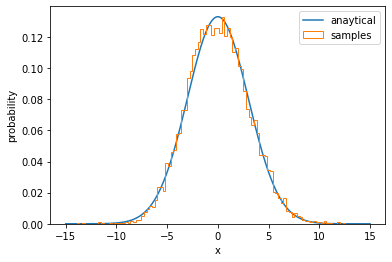

In [44]:
# Get pdf = exponential of log distribution
# Use input values for mean and scale
pdf = np.exp(log_prob(x, μ, σ))

# Normalise to unit area (because with MCMC it's tricky anyway to estimate the normalisation)
pdf = pdf / sum(pdf) / (x[1] - x[0])

# Plot
plt.plot(x, pdf, label='anaytical')

# Get chain points
samples = sampler.get_chain(flat=True)

# Plot estimated pdf which is proprtional to chain points density
plt.hist(samples[:, 0], 100, histtype="step", density=True, label='samples')
plt.legend()
plt.xlabel('x')
_ = plt.ylabel('probability')

Now we introduce a second non-normal distribution, and compare sampling under the combined
pdf versus the importance-sampling trick.

In [45]:
# Add another distribution.
# Set input  values
μ2 = 3
σ2 = 2

In [46]:
# Define second log pdf, this time not a normal distribution
def log_prob2(x, μ, σ):
    diff = x - μ
    return -0.5 * np.abs(diff/ σ)

In [47]:
# Combined log pdf = sum of individual log pdf's
def log_prob_comb(x, μ, σ, μ2, σ2):
    return log_prob(x, μ, σ) + log_prob2(x, μ2, σ2)

In [48]:
# Set up MCMC to sample under combined pdf
sampler_comb = emcee.EnsembleSampler(nwalkers, ndim, log_prob_comb, args=[μ, σ, μ2, σ2])

In [49]:
# Burn-in phase
state_comb = sampler_comb.run_mcmc(p0, n_burn)
sampler_comb.reset()

In [50]:
# Run MCMC
sampler_comb.run_mcmc(state, n_chain);

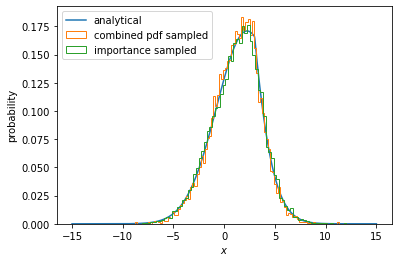

In [55]:
# Get combined pdf with input values
pdf_comb = np.exp(log_prob_comb(x, μ, σ, μ2, σ2))

# Normalise to unit area
pdf_comb = pdf_comb / sum(pdf_comb) / (x[1] - x[0])

_ = plt.plot(x, pdf_comb, label='analytical')

# Get sample points under combined pdf and plot
samples_comb = sampler_comb.get_chain(flat=True)
_ = plt.hist(
    samples_comb[:, 0],
    100,
    histtype="step",
    density=True,
    label='combined pdf sampled'
)

# Importance sampling: Get weights = pdf2 evaluated at sample points
weights = np.exp(log_prob2(samples[:, 0], μ2, σ2))

# Plot importance-sampled points by adding those weights to histogram
plt.hist(
    samples[:, 0],
    100,
    histtype="step",
    density=True,
    weights=weights,
    label='importance sampled'
)
plt.legend()
#plt.ylim()
plt.xlabel('$x$')
_ = plt.ylabel('probability')

Both chain do a good job to estimate the overall density!